# MNE data structure exploration notebook

In this notebook, we explore the possibilities of MNE. MNE is an open-source Python package for exploring, visualizing, and analyzing human neurophysiological data: MEG, EEG, sEEG, ECoG, NIRS, and more. It does not have a direct link to the paper but the expertise gained here is used in the paper.

This experimental notebook uses a database provided by [Kaya et al.](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. We will use the utility file `bci-master-thesis/code/utils/CLA_dataset.py` to work with this data, which gathered its functions from the experiments performed in `bci-master-thesis/experimental-notebooks/1-CLA-dataset-exploration-notebook.ipynb`.

For this MNE portion we used some of the tips and code samples from Richard Höchenberger's workshop on MNE Python:
- [Pybrain: M/EEG analysis with MNE Python](https://www.youtube.com/watch?v=t-twhNqgfSY)

## Table of Contents

- Checking requirements
  - Correct anaconda environment
  - Correct module access
  - Correct file access
- Loading in data
- Finding important markers
  - Loop for retrieving important markers
  - Analysing important markers
  - Plotting important markers
- Plotting with MNE
  - Plotting raw EEG data with MNE
  - Creating MNE annotations
  - Creating MNE events
- Storing the MNE RAW objects with more information

<hr><hr>

## Checking requirements

### Correct anaconda environment

The `bci-master-thesis` anaconda environment should be active to ensure proper support. Installation instructions are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

In [1]:
####################################################
# CHECKING FOR RIGHT ANACONDA ENVIRONMENT
####################################################

import os
from platform import python_version
from pathlib import Path

print(f"Active environment: {os.environ['CONDA_DEFAULT_ENV']}")
print(f"Correct environment: {os.environ['CONDA_DEFAULT_ENV'] == 'bci-master-thesis'}")
print(f"\nPython version: {python_version()}")
print(f"Correct Python version: {python_version() == '3.8.10'}")

Active environment: bci-master-thesis
Correct environment: True

Python version: 3.8.10
Correct Python version: True


<hr>

### Correct module access

The following codeblock will load in all required modules.

In [2]:
####################################################
# LOADING MODULES
####################################################

# Load util function file
import sys
sys.path.append('../utils')
import CLA_dataset

# Modules tailored for EEG data
import mne; print(f"MNE version (1.0.2 recommended): {mne.__version__}")

# Data manipulation modules
import numpy as np; print(f"Numpy version (1.21.5 recommended): {np.__version__}")

# Plotting
import matplotlib; print(f"Matplotlib version (3.5.1 recommended): {matplotlib.__version__}")
import matplotlib.pyplot as plt

MNE version (1.0.2 recommended): 1.0.2
Numpy version (1.21.5 recommended): 1.21.5
Matplotlib version (3.5.1 recommended): 3.5.1


<hr>

### Correct file access

As mentioned, this experimental notebook uses a database provided by [Kaya et al](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`.

In [3]:
####################################################
# CHECKING FILE ACCESS
####################################################

# Use util to determine if we have access
print("Full Matlab CLA file access: " + str(CLA_dataset.check_matlab_files_availability()))
print("Full MNE CLA file access: " + str(CLA_dataset.check_mne_files_availability()))

Full Matlab CLA file access: True
Full MNE CLA file access: True


<hr><hr>

## Loading in data

In this step, we load the data. The data is provided as `.mat` files and thus originally meant for use with MATLAB. However, thanks to the written `CLA_dataset` util file we can easily get the MNE raw data from it.

Please specify the filename in the below code block. For more info on which variants are available, please look at the `bci-master-thesis/code/data/CLA/README.md` file.

Remember the meaning of the markers:
- 0: “blank” or nothing is displayed in eGUI
    - Can be seen as a break between stimuli, thus random EEG data that should probably be ignored
- 1: Left hand action
    - EEG data for MI of the left hand
- 2: Right hand action
    - EEG data for MI of the right hand
- 3: Passive/neutral
    - EEG data for MI of neither left nor right hand but 'focused'
- 91: inter-session rest break period
- 92: experiment end
- 99: initial relaxation period

In [4]:
####################################################
# CHOOSING DATA RECORD
####################################################

# You can specify the data file to use here, per default it is CLASubjectA1601083StLRHand
data_file_name = "CLASubjectA1601083StLRHand"

Markers present: {0: 476168, 1: 61490, 2: 69202, 3: 64740}


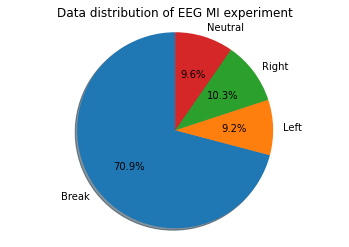

In [5]:
####################################################
# MARKERS DATA DISTRIBUTION
####################################################

# Save the markers from the raw matlab data
data_markers = CLA_dataset.get_raw_matlab_data(data_file_name).marker

# Show labels overview
unique, counts = np.unique(data_markers, return_counts=True)
count_dict = dict(zip(unique, counts))
print("Markers present: " + str(count_dict))

# Make pie chart out of data
labels = 'Break', 'Left', 'Right', 'Neutral'
sizes = [count_dict[0], count_dict[1], count_dict[2], count_dict[3]]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')
plt.title("Data distribution of EEG MI experiment")
plt.show()

# Cleaning up redundant variables from this codeblock
del unique
del counts
del fig
del ax
del count_dict
del labels
del sizes

In [6]:
####################################################
# MNE DATA
####################################################

# Load in the file as MNE
mne_raw = CLA_dataset.get_raw_mne_data(data_file_name)

# Show the info
mne_raw.info

# Remove data file name as it is not needed anymore
del data_file_name

<hr><hr>

## Finding important markers

Since the data is one continuous stream of EEG data and we have the marker for each `hertz` / datapoint, it might be a good idea to note the indexes at which these markers change. This will give us an idea of where the data changes from stimulus to stimulus.

### Loop for retrieving important markers

The following loop will collect all important markers from the dataset.

In [7]:
####################################################
# VALIDATING CORRECT LOADING OF MARKERS
####################################################

print("First 5: " + str(data_markers[:5]))

print("Marker size equal to number of time points: " + str(len(data_markers) == mne_raw.n_times))

First 5: [0 0 0 0 0]
Marker size equal to number of time points: True


In [8]:
####################################################
# MARKERS DATA DISTRIBUTION
####################################################

class ImportantMarker:
    def __init__(self, mark, old_mark, start_idx, end_idx):
        self.mark = mark
        self.old_mark = old_mark
        self.start_idx = start_idx
        self.end_idx = end_idx

In [9]:
####################################################
# DETERMINING IMPORTANT MARKERS
####################################################

# Initial values
important_markers = []
new_mark = old_mark = start_idx = end_indx = -1

for idx, marker in enumerate(data_markers):
    # Initial values
    if (start_idx == -1):
        start_idx = idx
        new_mark = old_mark = marker
        
    # Change of marker
    if (marker != new_mark):
        # Save marker
        end_indx = idx - 1
        important_markers.append(ImportantMarker(new_mark, old_mark, start_idx, end_indx))
        
        # Start new marker
        old_mark = new_mark
        new_mark = marker
        start_idx = idx
        
# End of loop, create last record if needed
if (start_idx > end_indx):
    # Save marker
    end_indx = idx
    important_markers.append(ImportantMarker(new_mark, old_mark, start_idx, end_indx))
        
# Cleaning up redundant variables from this codeblock
del new_mark
del old_mark
del start_idx
del end_indx
del idx
del marker

<hr>

### Analysing important markers

Below we perform some basic analysis of the data gathered from the important markers and try to validate they make sense.

In [10]:
####################################################
# VIEWING IMPORTANT MARKERS
####################################################

# View first 5
for important_marker in important_markers[:5]:
    print(f"Starting on {important_marker.start_idx} we changed from {important_marker.old_mark} to {important_marker.mark} Which lasted untill {important_marker.end_idx}")
    
print(f"\n\n... A total of {len(important_markers)} important markers ...\n\n")

# View last 5
for important_marker in important_markers[-5:]:
    print(f"Starting on {important_marker.start_idx} we changed from {important_marker.old_mark} to {important_marker.mark} Which lasted untill {important_marker.end_idx}")
    
# Show labels overview
unique, counts = np.unique([important_marker.mark for important_marker in important_markers], return_counts=True)
count_dict = dict(zip(unique, counts))
print("\n\nImportant markers distribution: " + str(count_dict))

# Determine time between marks
print("\n\nTime that a marker is shown, an action (mark 1, 2 or 3) should be 1 second, the short pause (mark 0) anywhere between 1.5-2.5 seconds")
print(f"Time that marker {important_markers[200].mark} is shown: {(important_markers[200].end_idx - important_markers[200].start_idx)/ mne_raw.info['sfreq']} sec")
print(f"Time that marker {important_markers[201].mark} is shown: {(important_markers[201].end_idx - important_markers[201].start_idx)/ mne_raw.info['sfreq']} sec")
print(f"Time that marker {important_markers[202].mark} is shown: {(important_markers[202].end_idx - important_markers[202].start_idx)/ mne_raw.info['sfreq']} sec")
print(f"Time that marker {important_markers[203].mark} is shown: {(important_markers[203].end_idx - important_markers[203].start_idx)/ mne_raw.info['sfreq']} sec")
print(f"Time that marker {important_markers[204].mark} is shown: {(important_markers[204].end_idx - important_markers[204].start_idx)/ mne_raw.info['sfreq']} sec")
print(f"Time that marker {important_markers[205].mark} is shown: {(important_markers[205].end_idx - important_markers[205].start_idx)/ mne_raw.info['sfreq']} sec")

# Delete unusued variables
del count_dict
del counts
del unique
del important_marker

Starting on 0 we changed from 0 to 0 Which lasted untill 37271
Starting on 37272 we changed from 0 to 3 Which lasted untill 37474
Starting on 37475 we changed from 3 to 0 Which lasted untill 37782
Starting on 37783 we changed from 0 to 3 Which lasted untill 37985
Starting on 37986 we changed from 3 to 0 Which lasted untill 38369


... A total of 1921 important markers ...


Starting on 667619 we changed from 3 to 0 Which lasted untill 667936
Starting on 667937 we changed from 0 to 2 Which lasted untill 668139
Starting on 668140 we changed from 2 to 0 Which lasted untill 668444
Starting on 668445 we changed from 0 to 3 Which lasted untill 668647
Starting on 668648 we changed from 3 to 0 Which lasted untill 671599


Important markers distribution: {0: 961, 1: 302, 2: 340, 3: 318}


Time that a marker is shown, an action (mark 1, 2 or 3) should be 1 second, the short pause (mark 0) anywhere between 1.5-2.5 seconds
Time that marker 0 is shown: 2.015 sec
Time that marker 1 is shown: 1.01 se

<hr>

### Plotting important markers

When plotting the evolution of these important markers it becomes clear that the stimulus is shown for 1 second (200 Hz) and the screen is blank for about 1.5 seconds (300 Hz).

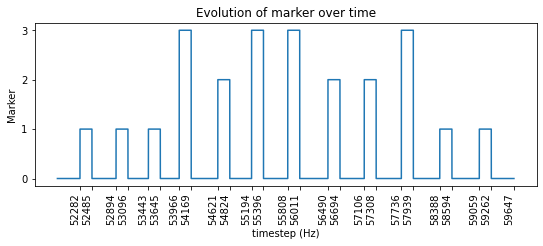

In [11]:
####################################################
# PLOTTING IMPORTANT MARKERS
####################################################

# Open plot inline
%matplotlib inline

# Data for plotting
subset_important_markers = important_markers[50:75]

# Setup canvas
plt.rcParams["figure.figsize"] = (9,3)

# Plotting code
x = sum([[x.start_idx, x.end_idx] for x in subset_important_markers], [])
y = sum([[y.mark, y.mark] for y in subset_important_markers], [])

fig, ax = plt.subplots()
ax.plot(x, y)

ax.set(xlabel='timestep (Hz)', ylabel='Marker',
       title='Evolution of marker over time')

# Only show every 1 in 2 x points
plt.xticks(x[1::2])
plt.yticks([0, 1, 2, 3])
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')

plt.show()
 
# Cleaning up redundant variables from this codeblock
del subset_important_markers
del fig
del ax
del x
del y

# Reset canvas
plt.rcParams.update(plt.rcParamsDefault)

<hr><hr>

## Plotting with MNE

### Plotting raw EEG data with MNE

Now that we have the `EMG RawArray object` and know the timestep of marker changes we can start making some interesting MNE plots. We will try this in what follows. We followed the [MNE documentation tutorials for this](https://mne.tools/dev/auto_tutorials/intro/10_overview.html). We note that the base data in the raw object stores the EEG in volts, not microvolts as originally in the MatLab CLA dataset. The conversion to volt was done by multiplying with $10e^{-6}$.

Effective window size : 10.240 (s)


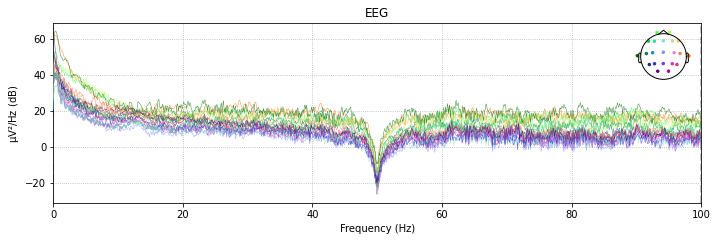

Effective window size : 10.240 (s)


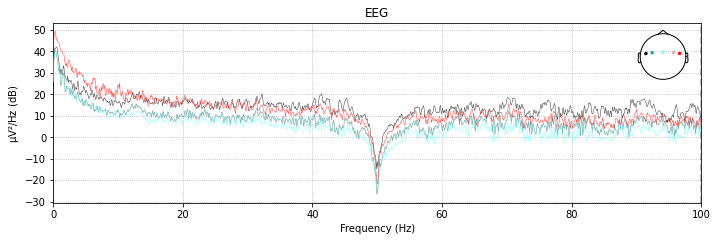

In [12]:
####################################################
# BASIC PLOTTING OF MNE DATA PT 1
####################################################

# Plot inline or in popup
%matplotlib inline
# %matplotlib qt 

# PSD plot for max allowed frequency taking into account nyquist theorem
## Show 300 seconds of data
max_freq = mne_raw.info['sfreq'] / 2
mne_raw.plot_psd(fmax=max_freq, 
                 tmin=2000, tmax=2300)

# Same plot but with filtered channels: +- motor cortex
max_freq = mne_raw.info['sfreq'] / 2
mne_raw.plot_psd(fmax=max_freq, 
                 tmin=2000, tmax=2300,
                 picks=["T3", "C3", "Cz", "C4", "T4"])

# Plot 
#mne_raw.plot(duration=5, n_channels=22)

# Remove unused variables
del max_freq

From the paper of the dataset by [Kaya et al](https://doi.org/10.1038/sdata.2018.211) we known certain things that we also notice, first of all:

> A 50 Hz notch filter is present in the EEG-1200 hardware to reduce electrical grid interference.

As well as:

> A band-pass filter of 0.53-70 Hz was present in all EEG data recorded at 200 Hz sampling rate in the Neurofax software.

While not important for this dataset, remmeber:

> A 0.53–100 Hz band-pass filter (the widest choice possible in Neurofax software) was applied to the EEG recordings acquired at 1000 Hz sampling rate.

We also show a plot where only a select few channels are shown based on:

> Hand movement is especially potent, due to easily distinguishable activity in the contra-lateral cortical regions responsible for the movement of the limbs, located directly under C3, C4, T3, T4 and Cz sites of the standard 10/20 international system. Thus, EEG-based discrimination of left- and right-hand MI based on contra-laterally localized activity observed via C3 and C4 electrodes has become one of the most easily deployable EEG BCI communication paradigms.

Using matplotlib as 2D backend.
Opening raw-browser...


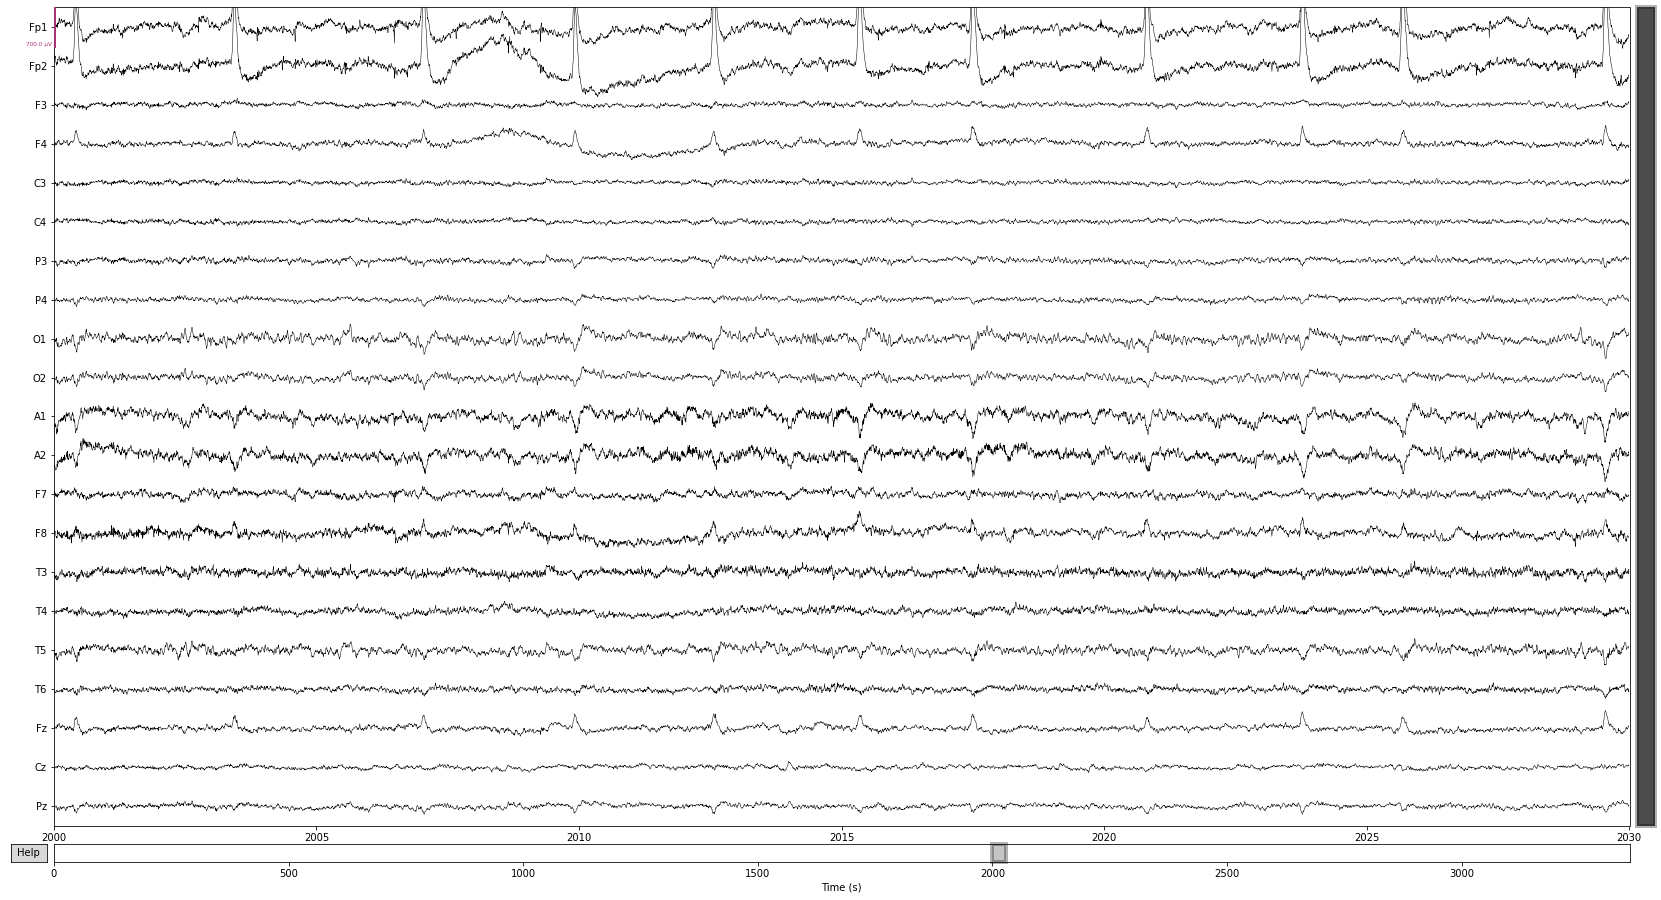

In [13]:
####################################################
# BASIC PLOTTING OF MNE DATA PT 2
####################################################

# Plot inline or in popup
%matplotlib inline
# %matplotlib qt 

# Default plot function scaled to usable visualisation of 30 seconds of data 
mne_raw.plot(duration=30,
             start=2000,
             scalings=dict(eeg=0.00035),
             n_channels=22)

plt.show()


We notice there is visually more activity on certain EEG channels than there is on others. These visual queues might hint that some channels will carry more information than others. Whilst these plots are interesting for a first look, it would be far more interesting to see them linked with the markers extracted earlier.

### Creating MNE annotations

In this section, we link the RAW MNE data with the information we have from the previously extracted markers.
This happens through MNE annotations and events, which are in large equal but [differ on some aspects](https://mne.tools/stable/auto_tutorials/intro/20_events_from_raw.html):
- **Units**: the Events data structure represents the when in terms of samples, whereas the Annotations data structure represents the when in seconds.
- **Limits on the description**: the Events data structure represents the what as an integer “Event ID” code, whereas the Annotations data structure represents the what as a string.
- **How duration is encoded**: Events in an Event array do not have a duration (though it is possible to represent duration with pairs of onset/offset events within an Events array), whereas each element of an Annotations object necessarily includes a duration (though the duration can be zero if an instantaneous event is desired).
- **Internal representation**: Events are stored as an ordinary NumPy array, whereas Annotations is a list-like class defined in MNE-Python.

 Remember the meaning of the markers:

Remember the meaning of the markers:
- 0: “blank” or nothing is displayed in eGUI
    - Can be seen as a break between stimuli, thus random EEG data that should probably be ignored
- 1: Left hand action
    - EEG data for MI of the left hand
- 2: Right hand action
    - EEG data for MI of the right hand
- 3: Passive/neutral
    - EEG data for MI of neither left nor right hand but 'focused'
- 91: inter-session rest break period
- 92: experiment end
- 99: initial relaxation period

In [14]:
####################################################
# CREATING MARKER TO TEXTUAL LINK
####################################################

# Link event ID (marker) with a textual description
marker_to_textual_dict = {0: "info/blank_screen",
                          1: "task/left",
                          2: "task/right",
                          3: "task/neutral",
                          91: "info/inter_session_break",
                          92: "info/experiment_end",
                          99: "info/initial_relaxation"}

print(f"Marker 1 has textual description: {marker_to_textual_dict[1]}")

# Make a dictionary linking description with a marker (inverse of previous dict)
textual_to_marker_dict = {value: key for key, value in marker_to_textual_dict.items()}

print(f"Textual description 'task/left' has marker: {textual_to_marker_dict['task/left']}")

Marker 1 has textual description: task/left
Textual description 'task/left' has marker: 1


We start by creating annotations.
Annotations are stored in the RAW MNE object under the annotations attribute.
We can add an annotation using the append function of that attribute and by providing:

- **onset**: Annotation time onset from the beginning of the recording in seconds.
- **duration**: Duration of the annotation in seconds.
- **description**: Description for the annotation. To reject epochs, use a description starting with the keyword ‘bad’.

Luckily, all of these things can be derived from the `ImportantMarker` class created earlier and the dictionaries created in the above code block.
It is important to remember to convert the sample index to a timestamp.

In [15]:
####################################################
# CREATING ANNOTATIONS FOR RAW MNE
####################################################

# Print before
print(f"Annotations initially in mne_raw object: {mne_raw.annotations.__len__()}")

# Clear annotations and print after clear
mne_raw.annotations.delete(list(range(mne_raw.annotations.__len__())))
print(f"\nAnnotations in mne_raw object after clearing: {mne_raw.annotations.__len__()}")

# Add annotations
important_marker: ImportantMarker
for important_marker in important_markers:
    # Go from sample index to seconds
    onset = important_marker.start_idx / mne_raw.info['sfreq']
    duration = (important_marker.end_idx - important_marker.start_idx) / mne_raw.info['sfreq']
    description = marker_to_textual_dict[important_marker.mark]
    
    mne_raw.annotations.append(onset= onset,
                               duration= duration,
                               description = description);

# Print final amount of annotations
print(f"\nAnnotations in mne_raw object after adding: {mne_raw.annotations.__len__()}")

# Remove unused vars
del important_marker
del onset
del duration
del description

Annotations initially in mne_raw object: 0

Annotations in mne_raw object after clearing: 0

Annotations in mne_raw object after adding: 1921


The annotations are added and should now be linked to the EEG data. Let's validate this by plotting the RAW MNE object again.

Opening raw-browser...


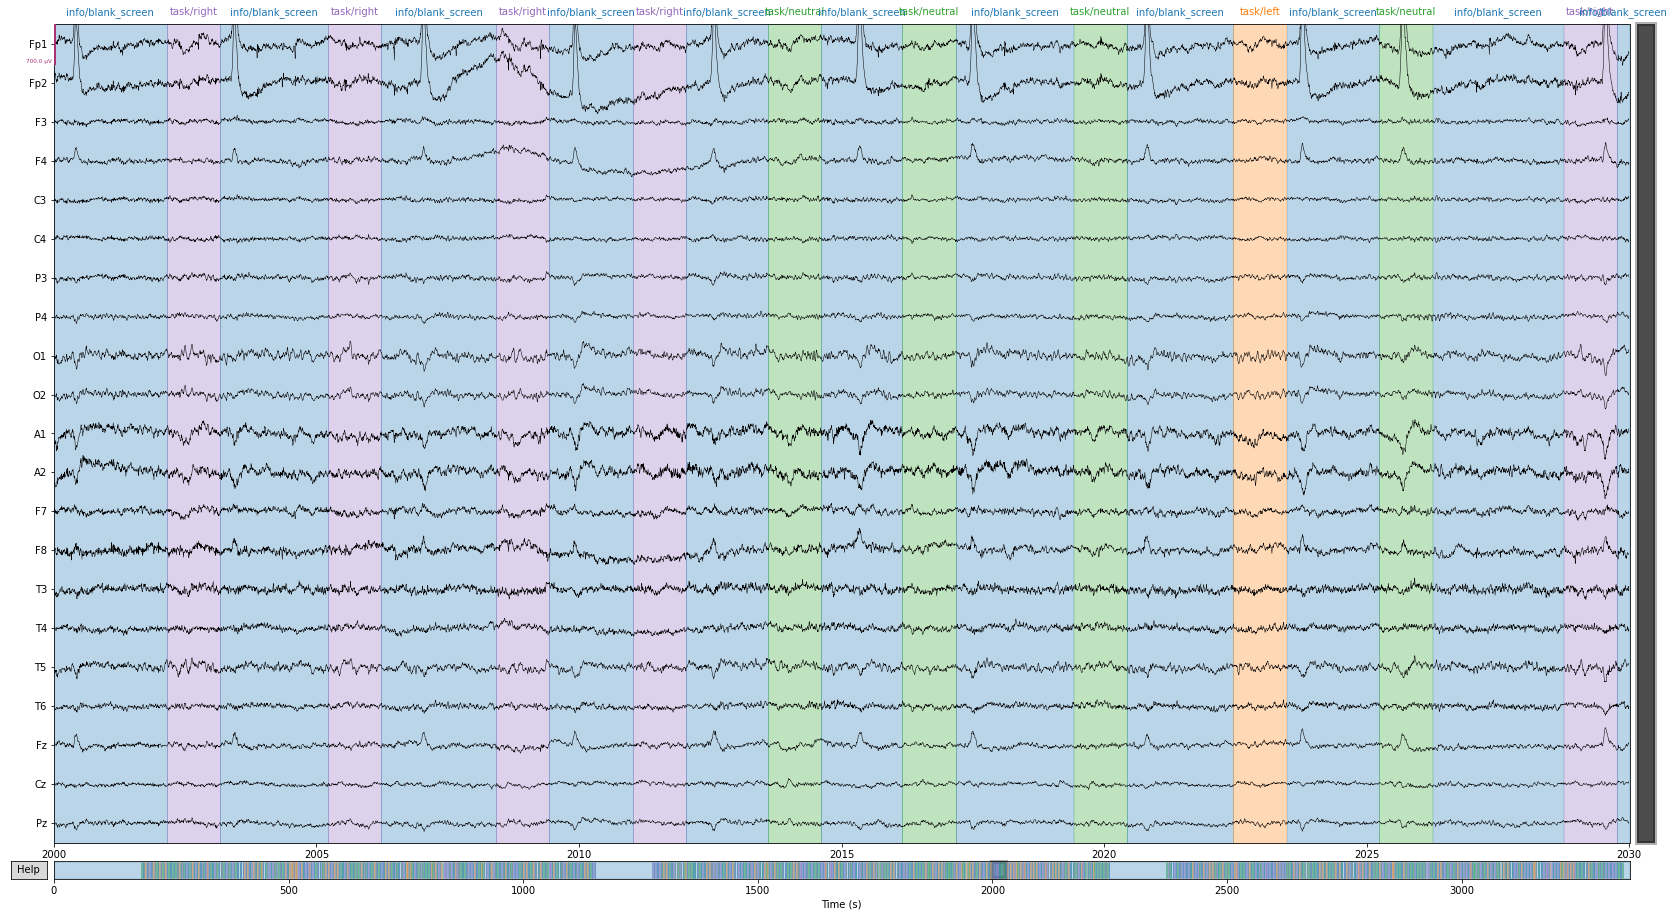

In [16]:
####################################################
# VALIDATING ANNOTATIONS
####################################################

# Plot inline or in popup
%matplotlib inline
# %matplotlib qt 

# Default plot function scaled to usable visualisation of 30 seconds of data 
mne_raw.plot(duration=30,
             start=2000,
             scalings=dict(eeg=0.00035),
             n_channels=22)

plt.show()


### Creating MNE events

From the annotations, MNE events can be created as well.
As discussed, events and annotations are largely the same.

Used Annotations descriptions: ['info/blank_screen', 'task/left', 'task/neutral', 'task/right']

IDs should be equal but list might be shorter due to lack of presence
Obtained:  {'info/blank_screen': 0, 'task/left': 1, 'task/neutral': 3, 'task/right': 2}
Used:  {'info/blank_screen': 0, 'task/left': 1, 'task/right': 2, 'task/neutral': 3, 'info/inter_session_break': 91, 'info/experiment_end': 92, 'info/initial_relaxation': 99}

Events counts should be equal to previously determined event counts.
Markers present: {0: 961, 1: 302, 2: 340, 3: 318}


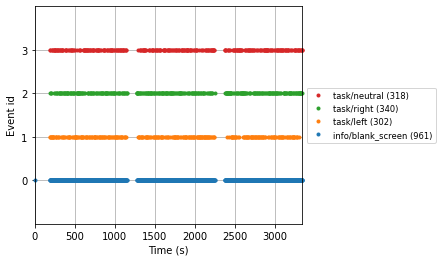

In [17]:
####################################################
# ANNOTATIONS TO EVENTS
####################################################

# Using building mne we can get the mne events and used dictionary for translation
## As we provide our own custom dict it should be equal
mne_events, mne_event_conversion_used_dict = mne.events_from_annotations(mne_raw, event_id=textual_to_marker_dict)

# Check conversion
print("\nIDs should be equal but list might be shorter due to lack of presence")
print("Obtained: ", mne_event_conversion_used_dict)
print("Used: ", textual_to_marker_dict)

# Show predicted events
print("\nEvents counts should be equal to previously determined event counts.")
unique, counts = np.unique([important_marker.mark for important_marker in important_markers], return_counts=True)
count_dict = dict(zip(unique, counts))
print("Markers present: " + str(count_dict))

# Plot events, not that the smaller dictionary should be provided
mne.viz.plot_events(mne_events,
                    event_id=mne_event_conversion_used_dict,
                    sfreq=mne_raw.info['sfreq'],
                    first_samp=mne_raw.first_samp)



# Remove unused variables
del mne_event_conversion_used_dict
del unique
del counts
del count_dict

We see that the events behave as expected, just like the annotations behaved as expected.

## Storing the MNE RAW objects with more information

As we now have the annotation information also stored in the RAW object, we create a loop to store these new MNE objects once again so that include this added information. we update the CLA_dataset util file as well.

In [18]:
####################################################
# UPDATING FIF FILES FOR ALL CLA DATASET
####################################################

for mne_filename in CLA_dataset.mne_filenames:
    # Get filename from path and remove the _raw suffix
    filename_only = Path(mne_filename).stem[:-4]
    print(f"\nWorking on file {filename_only}")
    
    # Load old MNE file
    raw_to_edit = CLA_dataset.get_raw_mne_data(filename_only)
    
    # Clear annotations
    print(f"Annotations initially in raw_to_edit object: {raw_to_edit.annotations.__len__()}")

    # Clear annotations and print after clear
    raw_to_edit.annotations.delete(list(range(raw_to_edit.annotations.__len__())))
    print(f"Annotations in raw_to_edit object after clearing: {raw_to_edit.annotations.__len__()}")
    
    
    # Get important markers
    crt_important_markers = CLA_dataset.get_important_markers(filename_only)
    
    # Create annotations
    for important_marker in crt_important_markers:
        # if non recognized marker -> skip
        if not important_marker.mark in marker_to_textual_dict:
            continue
        
        # Go from sample index to seconds
        onset = important_marker.start_idx / raw_to_edit.info['sfreq']
        duration = (important_marker.end_idx - important_marker.start_idx) / raw_to_edit.info['sfreq']
        description = marker_to_textual_dict[important_marker.mark]
        
        raw_to_edit.annotations.append(onset= onset,
                                       duration= duration,
                                       description = description)
    
    # Load in entire MNE RAW for saving
    raw_to_edit.load_data(verbose= False)
        
    # View annotations count
    print(f"Storing raw_to_edit object with {raw_to_edit.annotations.__len__()} annotations")
    
    # Store updated mne objects where annotations are added
    raw_to_edit.save(mne_filename, overwrite=True, verbose=False)
        
        
# Remove unused vars
del raw_to_edit
del filename_only
del onset
del description
del mne_filename
del duration
del important_marker
del crt_important_markers
    


Working on file CLASubjectA1601083StLRHand
Annotations initially in raw_to_edit object: 0
Annotations in raw_to_edit object after clearing: 0
Storing raw_to_edit object with 1921 annotations

Working on file CLASubjectB1510193StLRHand
Annotations initially in raw_to_edit object: 0
Annotations in raw_to_edit object after clearing: 0
Storing raw_to_edit object with 1919 annotations

Working on file CLASubjectB1510203StLRHand
Annotations initially in raw_to_edit object: 0
Annotations in raw_to_edit object after clearing: 0
Storing raw_to_edit object with 1919 annotations

Working on file CLASubjectB1512153StLRHand
Annotations initially in raw_to_edit object: 0
Annotations in raw_to_edit object after clearing: 0
Storing raw_to_edit object with 1921 annotations

Working on file CLASubjectC1511263StLRHand
Annotations initially in raw_to_edit object: 0
Annotations in raw_to_edit object after clearing: 0
Storing raw_to_edit object with 1921 annotations

Working on file CLASubjectC1512163StLRH

Opening raw-browser...


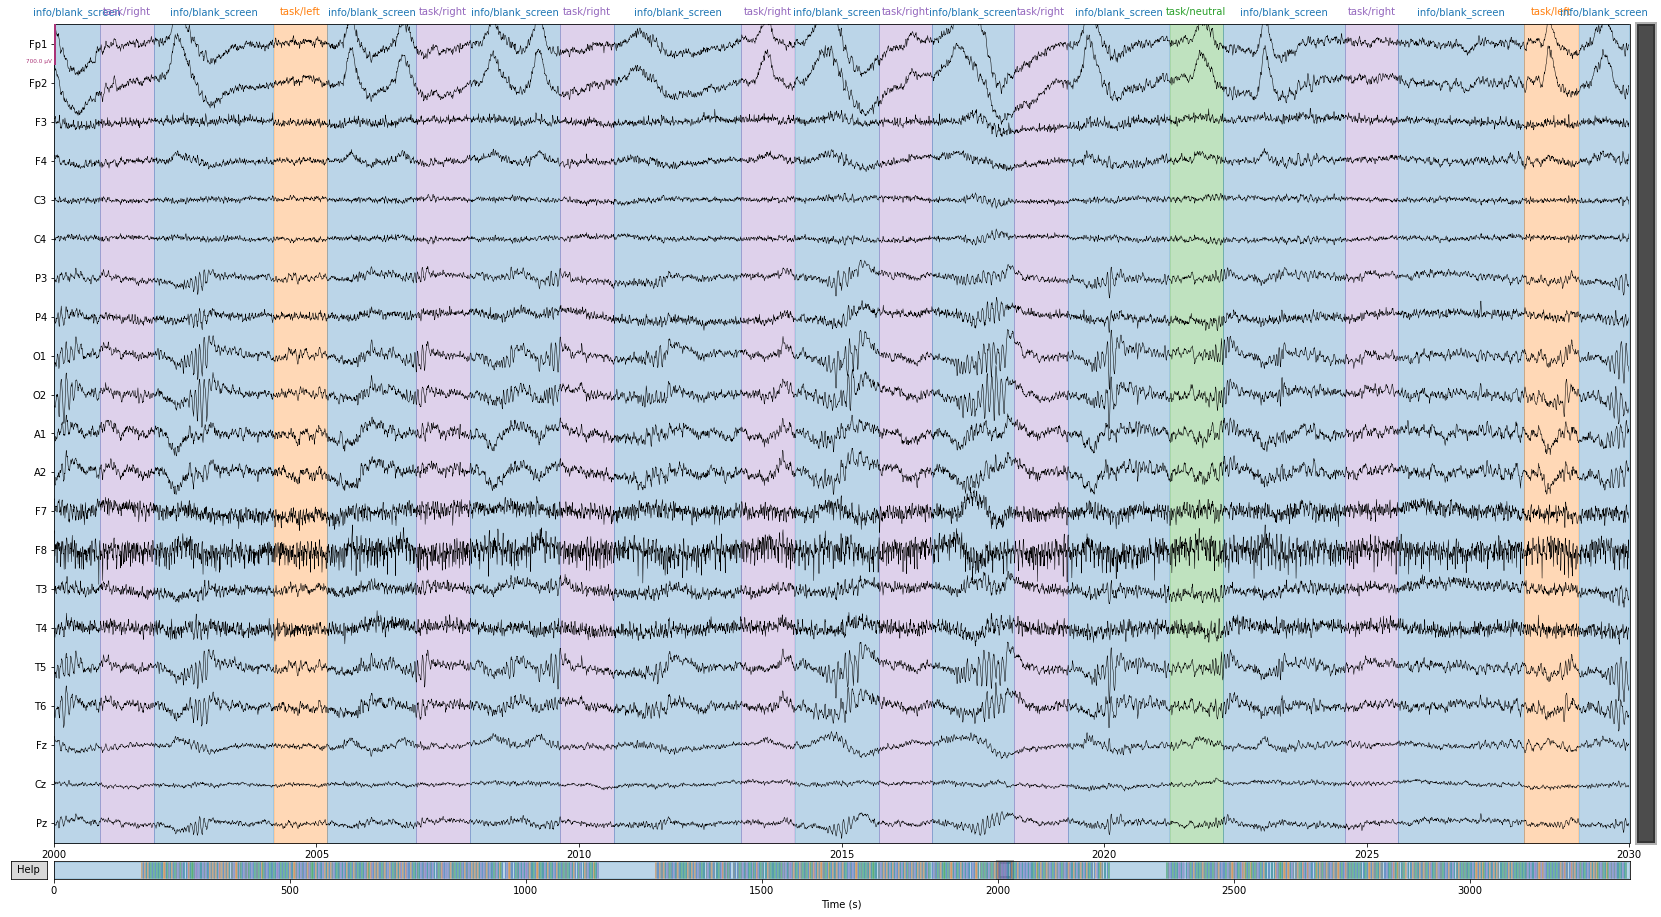

In [19]:
####################################################
# VALIDATE SAVED FIF
####################################################

mne_raw_test = CLA_dataset.get_raw_mne_data("CLASubjectD1511253StLRHand")

# Plot inline or in popup
%matplotlib inline
# %matplotlib qt 

# Default plot function scaled to usable visualisation of 30 seconds of data 
mne_raw_test.plot(duration=30,
                  start=2000,
                  scalings=dict(eeg=0.00035),
                  n_channels=22)

plt.show()

# Remove unused variable
del mne_raw_test